In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as ks
from numpy import hstack
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

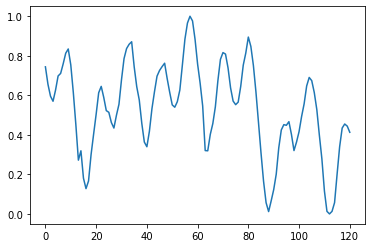

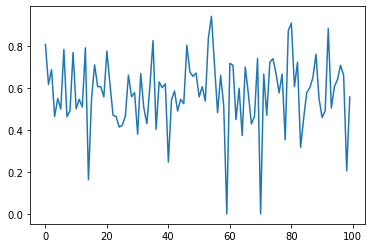

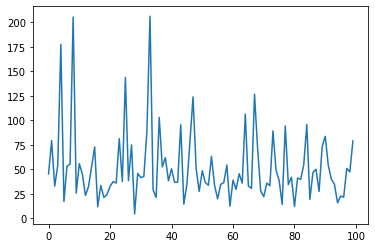

In [47]:
from numpy import load
# load array
X1 = load('Train1.npy')
X2 = load('Train2.npy')
y = load('Train_targets.npy')


# Test Plot
plt.figure()
plt.plot(X1[10,:,5])

plt.figure()
plt.plot(X2[:100,2])


plt.figure()
plt.plot(y[0:100])



In [48]:
def ModelPerformance(yp, yt):
    G1Tot = 0
    G1Correct = 0
    G2Tot = 0
    G2Correct = 0
    G3Tot = 0
    G3Correct = 0
    G4Tot = 0
    G4Correct = 0
    G5Tot = 0
    G5Correct = 0
    G6Tot = 0
    G6Correct = 0
    
    for i in range(len(yp)):
        if yt[i] <= 12:
            G1Tot += 1
            if yp[i] <= 12:
                G1Correct +=1
        elif yt[i] <= 35:
            G2Tot += 1
            if yp[i] > 12 and yp[i] <= 35:
                G2Correct += 1
        elif yt[i] <= 55:
            G3Tot += 1
            if yp[i] > 35 and yp[i] <= 55:
                G3Correct += 1
        elif yt[i] <= 150:
            G4Tot += 1
            if yp[i] > 55 and yp[i] <= 150:
                G4Correct += 1
        elif yt[i] <= 250:
            G5Tot += 1
            if yp[i] > 150 and yp[i] <= 250:
                G5Correct += 1
        elif yt[i] >250:
            G6Tot += 1
            if yp[i] > 250:
                G6Correct += 1
                
    MSE   = np.mean((yp-yt)**2)
    RMSE  = (MSE)**0.5
    MAPE  = np.mean(np.abs((yt-yp)/(yt)))
    OBAR  = np.mean(yt)
    IA    = 1 - np.sum((yp-yt)**2)/np.sum((np.abs(yp-OBAR) + np.abs(yt-OBAR))**2)
    G1acc = G1Correct/G1Tot * 100
    G2acc = G2Correct/G2Tot * 100
    G3acc = G3Correct/G3Tot * 100
    G4acc = G4Correct/G4Tot * 100
    G5acc = G5Correct/G5Tot * 100
    G6acc = G6Correct/G6Tot * 100
    Wacc  = ((G1acc*G1Correct)+(G2acc*G2Correct)+(G3acc*G3Correct)+(G4acc*G4Correct)+(G5acc*G5Correct)+(G6acc*G6Correct))/(len(yp))
    
    return [G1acc, G2acc, G3acc, G4acc, G5acc, G6acc, Wacc]

def build_FFNN(Xcombo):
    ffnnx = Input(shape=(Xcombo.shape[1]))
    cnnx = Dense(200, activation = 'swish')(ffnnx)
    cnnx = Dense(100, activation = 'swish')(cnnx)
    cnnx = Dense(50, activation = 'swish')(cnnx)
    cnnx = Dense(10, activation = 'swish')(cnnx)
    outputx = Dense(1)(cnnx)
    
#     modelX = Model(inputs=[ffnnx1,ffnnx2], outputs=outputx)
    modelX = Model(inputs=[ffnnx], outputs=outputx)
    modelX.compile(optimizer='adam', loss='mse', metrics = ['MeanAbsolutePercentageError', 'RootMeanSquaredError'])
    return modelX

print('FFNN MODEL')

X1FFN = np.reshape(X1,(X1.shape[0],X1.shape[1]*X1.shape[2]))
print(X1FFN.shape)
print(X2.shape)
Xcombo = np.concatenate((X1FFN,X2), axis = 1)



print(Xcombo.shape)

model_FFNN = build_FFNN(Xcombo)

model_FFNN.summary()

FFNN MODEL
(15539, 726)
(15539, 41)
(15539, 767)
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 767)]             0         
_________________________________________________________________
dense_110 (Dense)            (None, 200)               153600    
_________________________________________________________________
dense_111 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_112 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_113 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 11        
Total params: 179,271
Trainable params: 179,271
Non-trainable params: 0
___

In [49]:
# Baseline FFNN
train_idx = 12000 # 80% of data to
EPOCHS = 1000
BATCH = 256
early_stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=30,restore_best_weights = True, 
                                            min_delta = 5, verbose=2)


# print(X1)
# print(X2)
# print(y)


SimCount = 10
SimSaver = np.zeros((SimCount, 9)) # RMSE, MAPE, Class 1%, Class 2%, Class 3%, Class 4%, Class 5%, Class 6%, Weighted % - 9 columns
for i in range(SimCount):
    # RANDOMISING DATA
    ###############################################################
    randind = np.arange(len(y))
    np.random.shuffle(randind)
    tempX = Xcombo[randind]
    tempy1 = y[randind]
    
    
    # Training Data
    x1 = tempX[0:train_idx]
    y1 = tempy1[0:train_idx]
    

    
    # Testing Data
    testX = tempX[train_idx::]
    testy = tempy1[train_idx::]
    ################################################################
    
    # Create Model
    model_FFNN = build_FFNN(Xcombo)
    
    # Fit Model


    mFFNN_hist = model_FFNN.fit([x1], y1, epochs=EPOCHS,validation_split=0.15, verbose=0, callbacks = [early_stop], batch_size=BATCH, shuffle = True)
    
    # Evaluate Model
    MSE_save, RMSE_save, MAPE_save =  model_FFNN.evaluate([testX],testy)
    y_predict_FFNN = model_FFNN.predict([testX])
    
    # Append All Relevant Data To Matrix for Post Processing
    results = ModelPerformance(y_predict_FFNN, testy)
    
    SimSaver[i,0] = RMSE_save
    SimSaver[i,1] = MAPE_save
    SimSaver[i,2] = results[0]
    SimSaver[i,3] = results[1]
    SimSaver[i,4] = results[2]
    SimSaver[i,5] = results[3]
    SimSaver[i,6] = results[4]
    SimSaver[i,7] = results[5]
    SimSaver[i,8] = results[6]
    
    

Restoring model weights from the end of the best epoch.
Epoch 00084: early stopping
111/111 [==============================] - 0s 2ms/step - loss: 1060.3738 - mean_absolute_percentage_error: 42.1839 - root_mean_squared_error: 32.5488
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
111/111 [==============================] - 0s 2ms/step - loss: 1085.2255 - mean_absolute_percentage_error: 44.7480 - root_mean_squared_error: 32.9728
Restoring model weights from the end of the best epoch.
Epoch 00066: early stopping
111/111 [==============================] - 0s 2ms/step - loss: 1099.4734 - mean_absolute_percentage_error: 46.7396 - root_mean_squared_error: 33.1894
Restoring model weights from the end of the best epoch.
Epoch 00213: early stopping
111/111 [==============================] - 0s 2ms/step - loss: 943.0344 - mean_absolute_percentage_error: 36.8147 - root_mean_squared_error: 30.7189
Restoring model weights from the end of the best epoch.
Epoch 000

In [ ]:
# print(SimSaver)

# from numpy import save
# # Save Array
# save('FFNN_Results.npy', SimSaver)

In [ ]:
# from numpy import load
# # load array
# FFNN_Results = load('FFNN_Results.npy')

# print(FFNN_Results)

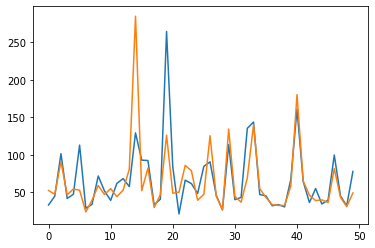

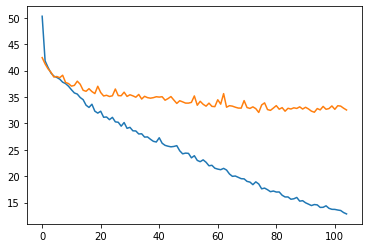

In [53]:
# Visually Evaluating Performance
start = 50
stop = start + 50



plt.figure()
plt.plot(testy[start:stop])
plt.plot(y_predict_FFNN[start:stop])


plt.figure()
plt.plot(np.sqrt(mFFNN_hist.history['loss']))
plt.plot(np.sqrt(mFFNN_hist.history['val_loss']))